In [3]:
pip install nibabel

In [4]:
#El dataset lo tenemos guardado en Google Drive, entonces lo importamos desde allí
from google.colab import drive    #para poder acceder a Google drive
drive.mount('/content/drive')     #montamos la carpeta de Drive
import os

#Ahora indicaremos acá la ruta de la carpeta que contiene el conjunto de datos
folder_path = '/content/drive/MyDrive/HeartDisease/training/'

Mounted at /content/drive


In [5]:
import numpy as np
import nibabel as nib              # para leer archivos .nii
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import glob # This needs to be imported

In [6]:
def cargar_datos(carpeta_raiz):
    imagenes = []
    mascaras = []

    for subcarpeta in os.listdir(carpeta_raiz):
        ruta_subcarpeta = os.path.join(carpeta_raiz, subcarpeta)
        if not os.path.isdir(ruta_subcarpeta):
            continue

        for archivo in os.listdir(ruta_subcarpeta):
            if archivo.endswith('.nii.gz') and ('frame01.nii.gz' in archivo or 'frame12.nii.gz' in archivo) and not '_gt.nii.gz' in archivo:
                ruta_img = os.path.join(ruta_subcarpeta, archivo)
                ruta_gt = ruta_img.replace('.nii.gz', '_gt.nii.gz')

                if not os.path.exists(ruta_gt):
                    continue

                img_vol = nib.load(ruta_img).get_fdata()
                msk_vol = nib.load(ruta_gt).get_fdata()

                if img_vol.shape != msk_vol.shape:
                    print(f"Skipping {archivo} due to shape mismatch: img {img_vol.shape}, mask {msk_vol.shape}")
                    continue

                if img_vol.ndim != 3:
                    print(f"Skipping {archivo} due to non-3D volume: img {img_vol.shape}")
                    continue

                for i in range(img_vol.shape[2]):  # Recorrer cada slice
                    img_slice = img_vol[:, :, i]
                    msk_slice = msk_vol[:, :, i]

                    if np.max(msk_slice) == 0:
                        continue  # Saltar slices sin información útil

                    # Normalizar imagen
                    img_slice = (img_slice - np.min(img_slice)) / (np.max(img_slice) - np.min(img_slice) + 1e-8)

                    # Redimensionar a 256x256 y expandir canal
                    img_slice = tf.image.resize(img_slice[..., np.newaxis], [256, 256]).numpy()
                    msk_slice = tf.image.resize(msk_slice[..., np.newaxis], [256, 256]).numpy()

                    imagenes.append(img_slice)
                    mascaras.append(msk_slice)

    if len(imagenes) == 0 or len(mascaras) == 0:
        raise ValueError("No se cargaron imágenes o máscaras válidas")

    X = np.array(imagenes, dtype=np.float32)
    Y = np.array(mascaras, dtype=np.float32)

    return X, Y


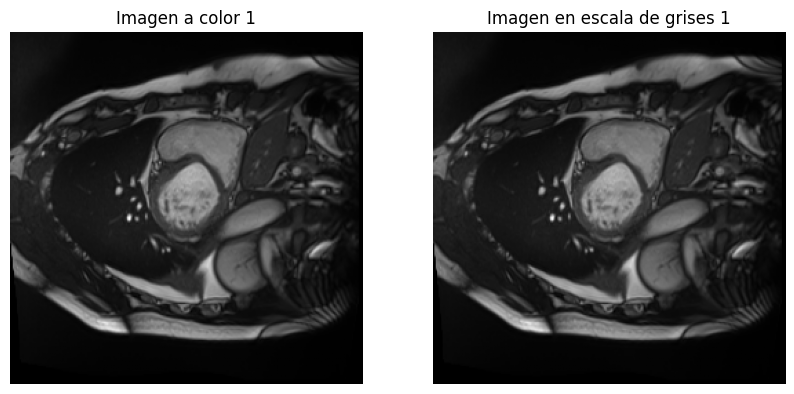

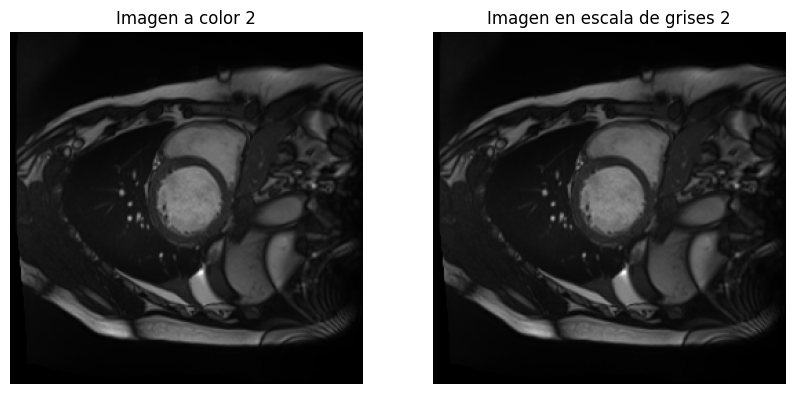

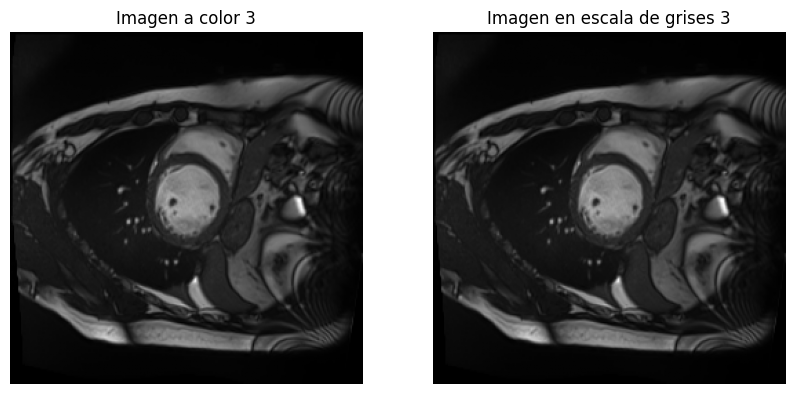

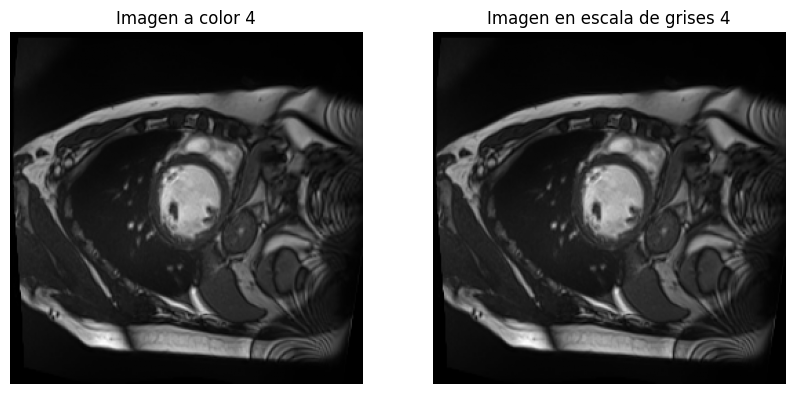

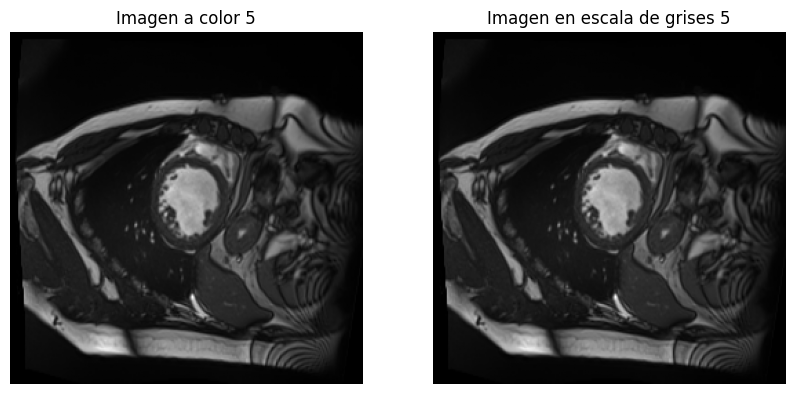

In [7]:
# mostrar imagenes a color y escala de grises

# Cargar datos (asumiendo que la función cargar_datos está definida como en el código anterior)
X, Y = cargar_datos(folder_path)

# Mostrar algunas imágenes a color y escala de grises
num_images_to_show = 5  # Número de imágenes a mostrar

for i in range(num_images_to_show):
    plt.figure(figsize=(10, 5))

    # Imagen a color
    plt.subplot(1, 2, 1)
    plt.imshow(X[i, :, :, 0], cmap='gray')  # Mostrar la imagen en escala de grises
    plt.title(f"Imagen a color {i+1}")
    plt.axis('off')

    # Imagen en escala de grises
    plt.subplot(1, 2, 2)
    plt.imshow(X[i, :, :, 0], cmap='gray')  # Mostrar la imagen en escala de grises
    plt.title(f"Imagen en escala de grises {i+1}")
    plt.axis('off')

    plt.show()

In [8]:
# Paso 3: Definir la arquitectura U-Net
# Paso 3: Definir la arquitectura U-Net
def unet_model(input_size=(256, 256, 1), num_classes=4):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(64, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(128, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D()(c3)

    # Bridge
    c4 = layers.Conv2D(256, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(256, 3, activation='relu', padding='same')(c4)

    # Decoder
    u5 = layers.UpSampling2D()(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = layers.Conv2D(128, 3, activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(128, 3, activation='relu', padding='same')(c5)

    u6 = layers.UpSampling2D()(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(64, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(64, 3, activation='relu', padding='same')(c6)

    u7 = layers.UpSampling2D()(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(32, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(32, 3, activation='relu', padding='same')(c7)

    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(c7)

    model = models.Model(inputs, outputs)
    return model


In [9]:
import tensorflow.keras.backend as K

# Dice Coefficient
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# IoU (Intersection over Union)
def iou_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

In [10]:
def entrenar_modelo(base_path):
    X, Y = cargar_datos(base_path)

    # Asegurarse que X tiene forma (batch, height, width, channels)
    if X.ndim == 3:
        X = X[..., np.newaxis]
    elif X.ndim == 2:
        X = np.expand_dims(np.expand_dims(X, axis=0), axis=-1)
    elif X.ndim == 1:
        X = np.expand_dims(np.expand_dims(np.expand_dims(X, axis=0), axis=-1), axis=0)

    # Redimensionar imágenes a 256x256
    X = tf.image.resize(X, [256, 256]).numpy()

    # Preparar Y
    if Y.ndim < 3:
        while Y.ndim < 3:
            Y = np.expand_dims(Y, axis=-1)
    Y = tf.image.resize(Y, [256, 256], method='nearest').numpy()
    Y = Y.squeeze(axis=-1).astype(np.uint8)
    Y = tf.one_hot(Y, depth=4)

    # División en entrenamiento, validación y prueba
    X_temp, X_test, Y_temp, Y_test = train_test_split(X, Y.numpy(), test_size=0.1, random_state=42)
    X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=0.1, random_state=42)

    # Modelo
    model = unet_model(input_size=(256, 256, 1), num_classes=4)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', dice_coef, iou_coef])

    # Entrenamiento
    history = model.fit(X_train, Y_train,
                        validation_data=(X_val, Y_val),
                        epochs=30,
                        batch_size=8)

    # Guardar modelo
    model.save('unet_heart_segmentation.h5')

    # Graficar métricas
    plt.figure(figsize=(18, 5))

    # Pérdida
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Pérdida Entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida Validación')
    plt.title('Pérdida')
    plt.xlabel('Épocas')
    plt.ylabel('Valor')
    plt.legend()

    # Dice
    plt.subplot(1, 3, 2)
    plt.plot(history.history['dice_coef'], label='Dice Entrenamiento')
    plt.plot(history.history['val_dice_coef'], label='Dice Validación')
    plt.title('Dice Coefficient')
    plt.xlabel('Épocas')
    plt.ylabel('Valor')
    plt.legend()

    # IoU
    plt.subplot(1, 3, 3)
    plt.plot(history.history['iou_coef'], label='IoU Entrenamiento')
    plt.plot(history.history['val_iou_coef'], label='IoU Validación')
    plt.title('Intersection over Union (IoU)')
    plt.xlabel('Épocas')
    plt.ylabel('Valor')
    plt.legend()

    plt.tight_layout()
    plt.show()
    return model, X_test, Y_test


In [ ]:
model, X_test, Y_test = entrenar_modelo(folder_path)

Epoch 1/30
 79/113 ━━━━━━━━━━━━━━━━━━━━ 9:17 16s/step - accuracy: 0.9053 - dice_coef: 0.8067 - iou_coef: 0.7223 - loss: 0.4149

In [ ]:
# Cargar imágenes para prueba (por ejemplo, del mismo set de entrenamiento)
base_path = folder_path
imagenes, _ = cargar_datos(base_path)  # solo imágenes
# Load the trained model
model = tf.keras.models.load_model('unet_heart_segmentation.h5')
# Predecir
predicciones = model.predict(imagenes)

# Obtener la clase más probable por pixel
pred_clases = tf.argmax(predicciones, axis=-1).numpy()

# Visualizar
print("Visualizando resultado de segmentación...")
visualizar_resultado(imagenes, pred_clases, 2)